In [1]:
using PyPlot

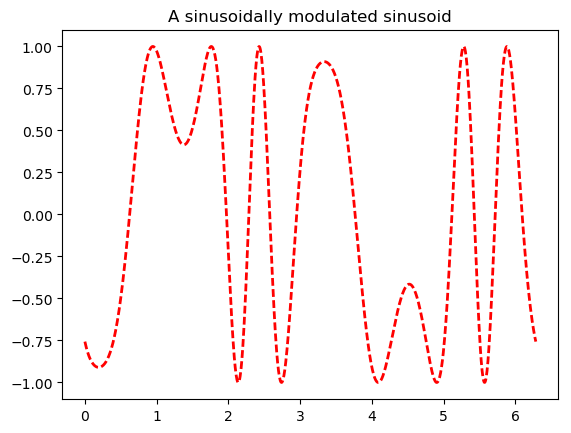

PyObject <matplotlib.text.Text object at 0x7f21724f4a90>

In [2]:
x = linspace(0,2*pi,1000); y = sin(3*x + 4*cos(2*x));
plot(x, y, color="red", linewidth=2.0, linestyle="--")
title("A sinusoidally modulated sinusoid")

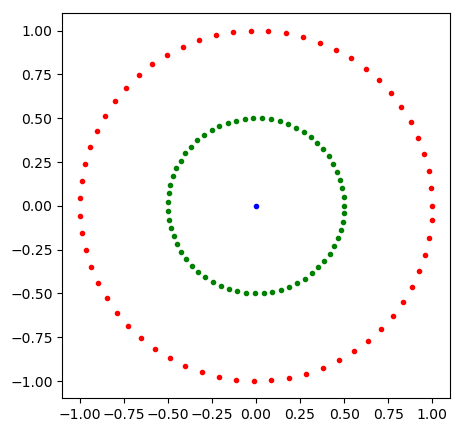

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2172378190>

In [3]:
figure(figsize=(5, 5))
θ = collect(0:0.1:2π)
plot(0,0,"b.")
plot(cos(θ), sin(θ), "r.")
plot(0.5cos(θ), 0.5sin(θ), "g.")

In [4]:
using ScikitLearn
@sk_import datasets: make_moons

PyObject <function make_moons at 0x7f2169c9f140>

In [5]:
X, y = make_moons(200, noise=0.20)

(
[-0.224193 1.16537; 0.644526 0.080947; … ; -0.812634 0.707923; 0.852514 0.245306],

[0,0,1,1,0,0,1,0,0,1  …  0,1,1,0,1,0,1,1,0,0])

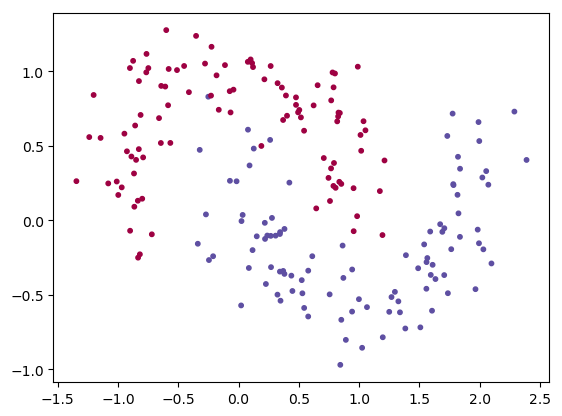

PyObject <matplotlib.collections.PathCollection object at 0x7f2169815110>

In [6]:
scatter(X[1:200,1], X[1:200,2], c=y,s=10,cmap=:Spectral)

In [7]:
using ScikitLearn.Utils: meshgrid

In [8]:
min(X[1:200,1]...)

-1.345315834393665

In [9]:
function plot_decision_boundary(pred_func)
    x_min, x_max = minimum(X[:,1]) - .5, maximum(X[:,1]) + .5
    y_min, y_max = minimum(X[:,2]) - .5, maximum(X[:,2]) + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy = meshgrid(x_min:h:x_max, y_min:h:y_max)
    cm = PyPlot.cm[:RdBu]
    # Predict the function value for the whole gid
    Z = pred_func(hcat(xx[:],yy[:]))
    Z = reshape(Z, size(xx)...)
    # Plot the contour and training examples
    contourf(xx, yy, Z, cmap=cm, alpha=.8)
    scatter(X[1:200,1], X[1:200,2], c=y,s=10,cmap=cm)
end

plot_decision_boundary (generic function with 1 method)

In [10]:
@sk_import linear_model: LogisticRegressionCV

PyObject <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>

In [11]:
clf = LogisticRegressionCV()

PyObject LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [12]:
fit!(clf, X, y)

PyObject LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

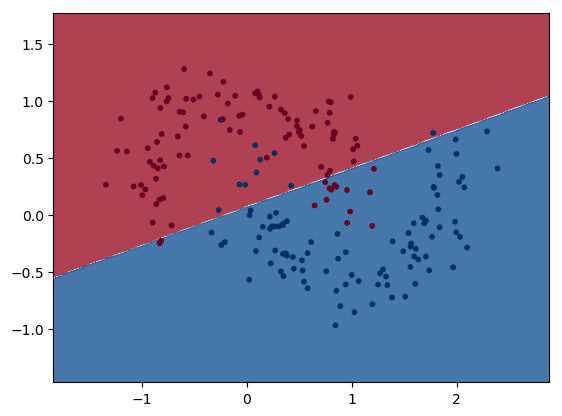

PyObject <matplotlib.collections.PathCollection object at 0x7f21664053d0>

In [13]:
plot_decision_boundary( (x)-> predict(clf, x) )

In [14]:
num_example = 200
nn_input_dim = 2
nn_output_dim = 2

ϵ =  0.01
reg_λ = 0.01

0.01

In [15]:
function calc_loss(model::Dict{Symbol, AbstractArray})
    W1, W2, b1, b2 = model[:W1], model[:W2], model[:b1], model[:b2]
    z1 = X * W1 .+ b1'
    a1 = tanh(z1)
    z2 = a1 * W2 .+ b2'
    exp_scores = exp(z2)
    probs = exp_scores ./ sum(exp_scores, 2)
    correct_logprobs = - log.(probs[ [ j-1==y[i] for i=1:num_example, j=1:nn_input_dim] ])
    data_loss = sum(correct_logprobs)
    data_loss += (reg_λ / 2) * (sum(W1.^2) + sum(W2.^2)) 
    return 1./num_example * data_loss
end

calc_loss (generic function with 1 method)

In [16]:
function Predict(model::Dict{Symbol, AbstractArray}, x)
    W1, W2, b1, b2 = model[:W1], model[:W2], model[:b1], model[:b2]
    z1 = x * W1 .+ b1'
    a1 = tanh(z1)
    z2 = a1 * W2 .+ b2'
    exp_scores = exp(z2)
    probs = exp_scores ./ sum(exp_scores, 2)
    return ind2sub(size(probs), vec(findmax(probs, 2)[2]))[2] - 1
end

Predict (generic function with 1 method)

In [17]:
function build_model(nn_hdim::Int; num_passess::Int = 20_000, print_loss::Bool = false)
    #srand(214)
    W1 = rand(nn_input_dim, nn_hdim) / √nn_input_dim
    b1 = zeros(nn_hdim)
    W2 = rand(nn_hdim, nn_output_dim) / √nn_hdim
    b2 = zeros(nn_output_dim)
    
    model = Dict{Symbol, AbstractArray}()
    for i in 1:num_passess
        z1 = X * W1 .+ b1'
        a1 = tanh(z1)
        z2 = a1 * W2 .+ b2'
        exp_scores = exp(z2)
        probs = exp_scores ./ sum(exp_scores, 2)
        
        δ3 = probs
        δ3 -=  [ Float64(j-1==y[i]) for i=1:num_example, j=1:nn_input_dim] 
        dW2 = a1' * δ3
        db2 = sum(δ3, 1)
        δ2 = δ3 * W2' .* (1 .- a1.^2)
        dW1 = X' * δ2
        db1 = sum(δ2, 1)
        
        dW2 += reg_λ * W2
        dW1 += reg_λ * W1
        
        W1 += -ϵ * dW1
        b1 += -ϵ * db1'
        W2 += -ϵ * dW2
        b2 += -ϵ * db2'
        
        if print_loss && i % 1000 == 0
            model[:W1], model[:W2], model[:b1], model[:b2] = W1, W2, b1, b2
            loss = calc_loss(model)
            println("Loss after iteration $i: $loss")
        end
    end
    model[:W1], model[:W2], model[:b1], model[:b2] = W1, W2, b1, b2
    return model
end

build_model (generic function with 1 method)

In [18]:
model = build_model(3, print_loss=true)

Loss after iteration 1000: 0.23414168145647704
Loss after iteration 2000: 0.06122943236504725
Loss after iteration 3000: 0.04857422875887645
Loss after iteration 4000: 0.048095864544323276
Loss after iteration 5000: 0.04932512766185489
Loss after iteration 6000: 0.049336982359787396
Loss after iteration 7000: 0.049343862272989085
Loss after iteration 8000: 0.04934906726620856
Loss after iteration 9000: 0.04935474362364846
Loss after iteration 10000: 0.049361017315797666
Loss after iteration 11000: 0.04936733886397297
Loss after iteration 12000: 0.049373176449290075
Loss after iteration 13000: 0.04937822161341039
Loss after iteration 14000: 0.049382376789751846
Loss after iteration 15000: 0.04938568142153352
Loss after iteration 16000: 0.049388243040172565
Loss after iteration 17000: 0.049390190870872715
Loss after iteration 18000: 0.04939165010889848
Loss after iteration 19000: 0.049392730269502944
Loss after iteration 20000: 0.04939352169932664


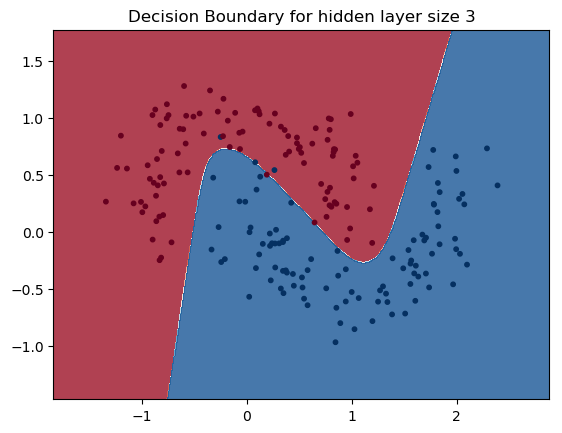

PyObject <matplotlib.collections.PathCollection object at 0x7f2164351610>

In [19]:
plt[:title]("Decision Boundary for hidden layer size 3")
plot_decision_boundary( (x)-> Predict(model, x) )

In [20]:
model

Dict{Symbol,AbstractArray} with 4 entries:
  :b1 => [-1.48645; -1.93312; -5.79253]
  :W1 => [-2.56414 2.68477 4.13238; 0.423835 2.62829 -1.33759]
  :W2 => [4.60429 -4.47657; 3.89796 -3.78779; -4.14659 4.20003]
  :b2 => [0.416017; -0.416017]

In [21]:
model2 = build_model(10, print_loss=true)

Loss after iteration 1000: 0.05302315669461726
Loss after iteration 2000: 0.04754024127013706
Loss after iteration 3000: 0.04585830127197332
Loss after iteration 4000: 0.044608459776983626
Loss after iteration 5000: 0.043327496223263325
Loss after iteration 6000: 0.04236026555173516
Loss after iteration 7000: 0.04165990971970104
Loss after iteration 8000: 0.04102977223856272
Loss after iteration 9000: 0.04032931853166411
Loss after iteration 10000: 0.03955174995788958
Loss after iteration 11000: 0.03922433397534222
Loss after iteration 12000: 0.03902620795354699
Loss after iteration 13000: 0.0388189195899569
Loss after iteration 14000: 0.038567783447486036
Loss after iteration 15000: 0.03820827943774753
Loss after iteration 16000: 0.037670354163652046
Loss after iteration 17000: 0.03696953640918498
Loss after iteration 18000: 0.036248388983179426
Loss after iteration 19000: 0.03565983262113747
Loss after iteration 20000: 0.03524962933708078


Dict{Symbol,AbstractArray} with 4 entries:
  :b1 => [2.38388; 4.83086; … ; -2.19; -4.23233]
  :W1 => [0.113874 -3.18462 … 2.46469 -7.25493; -0.160185 -0.549119 … 2.39084 1…
  :W2 => [-0.670827 0.720382; 2.67621 -2.60636; … ; 3.36159 -3.31474; 4.33673 -…
  :b2 => [-1.37101; 1.37101]

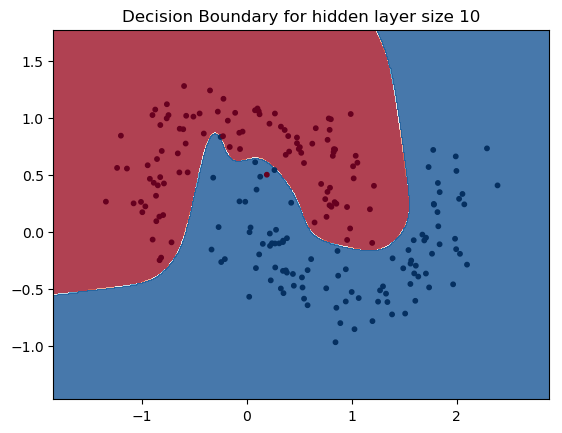

PyObject <matplotlib.collections.PathCollection object at 0x7f216429c490>

In [22]:
plt[:title]("Decision Boundary for hidden layer size 10")
plot_decision_boundary( (x)-> Predict(model2, x) )

In [23]:
model2

Dict{Symbol,AbstractArray} with 4 entries:
  :b1 => [2.38388; 4.83086; … ; -2.19; -4.23233]
  :W1 => [0.113874 -3.18462 … 2.46469 -7.25493; -0.160185 -0.549119 … 2.39084 1…
  :W2 => [-0.670827 0.720382; 2.67621 -2.60636; … ; 3.36159 -3.31474; 4.33673 -…
  :b2 => [-1.37101; 1.37101]